## GAN

build and train a Generative Adversarial Network (GAN) using the Keras library in Python to generate synthetic handwritten digits similar to those in the MNIST dataset.

In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Load Data and Explore

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 56681115.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1759261.27it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13943469.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3207159.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(train_ds.data.shape)

torch.Size([60000, 28, 28])


In [4]:
print(train_ds.targets.shape)

torch.Size([60000])


In [5]:
print(train_ds.classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [6]:
print(train_ds.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
print(train_ds.targets[0])

tensor(5)


In [8]:
print(train_ds.data[0].max())

tensor(255, dtype=torch.uint8)


In [9]:
print(train_ds.data[0].min())

tensor(0, dtype=torch.uint8)


In [10]:
print(train_ds.data[0].float().mean())

tensor(35.1084)


In [11]:
print(train_ds.data[0].float().std())

tensor(79.6997)


## Build dataloader

In [12]:
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

## Examine a sample batch from the dataloader

In [13]:
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


## Visualize a sample batch

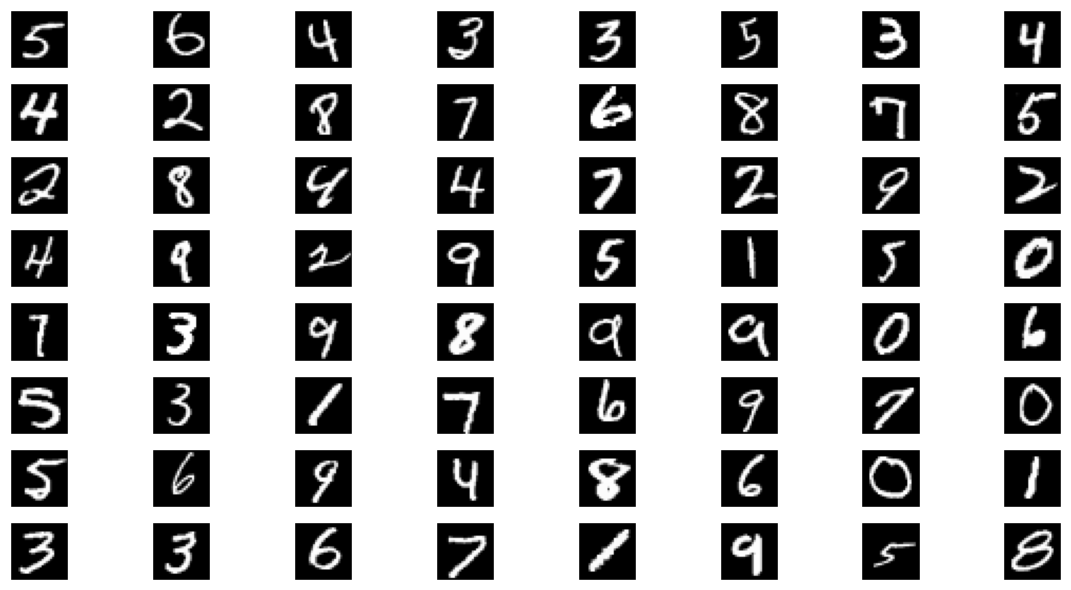

In [14]:
def display_images(images, n_cols=4, figsize=(12, 6)):

    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

## Define the Network
### Discriminator Network

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)

        return logit_out

## Generator Network

In [16]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()


    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out

## Define Losses

In [17]:
def real_loss(predicted_outputs, loss_fn, device):

    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):

    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)

    return fake_loss

## Train the network

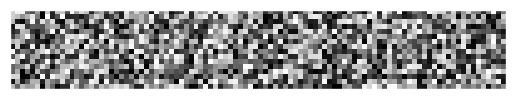

In [18]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Training Loop function

In [19]:
# Training loop function

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')

    # Generate a batch (say 16) of latent image vector (z) of fixed size
    # (say 100 pix) to be as input to the Generator after each epoch of
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []


    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)

            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------

            # Reset gradients
            d_optim.zero_grad()

            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = (real_images * 2) - 1
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)

            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z)
            # feed fake-images to discriminator and compute the
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss

            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()

            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss
            # (i.e. target label = 1)
            fake_images = g(z)
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss

            # Display training stats for every 200 batches
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')

        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)

        # Display training stats for every 200 batches
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')

        # Generate fake images from fixed latent vector using the trained
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())

    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

## Prepre and start training


In [20]:
# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)


In [21]:
# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim,
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Training on [cuda]...
Epoch [1/100]:
epoch_d_loss: 1.137653 	epoch_g_loss: 2.120743
Epoch [2/100]:
epoch_d_loss: 1.132466 	epoch_g_loss: 1.808812
Epoch [3/100]:
epoch_d_loss: 0.960981 	epoch_g_loss: 1.607620
Epoch [4/100]:
epoch_d_loss: 0.888808 	epoch_g_loss: 1.834982
Epoch [5/100]:
epoch_d_loss: 1.020766 	epoch_g_loss: 1.470664
Epoch [6/100]:
epoch_d_loss: 1.066765 	epoch_g_loss: 1.302803
Epoch [7/100]:
epoch_d_loss: 1.178831 	epoch_g_loss: 1.089851
Epoch [8/100]:
epoch_d_loss: 1.195314 	epoch_g_loss: 1.038641
Epoch [9/100]:
epoch_d_loss: 1.176722 	epoch_g_loss: 1.087673
Epoch [10/100]:
epoch_d_loss: 1.240347 	epoch_g_loss: 0.964981
Epoch [11/100]:
epoch_d_loss: 1.246996 	epoch_g_loss: 0.969720
Epoch [12/100]:
epoch_d_loss: 1.231457 	epoch_g_loss: 1.001387
Epoch [13/100]:
epoch_d_loss: 1.189703 	epoch_g_loss: 1.067484
Epoch [14/100]:
epoch_d_loss: 1.232169 	epoch_g_loss: 0.980856
Epoch [15/100]:
epoch_d_loss: 1.228208 	epoch_g_loss: 0.974275
Epoch [16/100]:
epoch_d_loss: 1.240951 	ep

## Visualize training losses


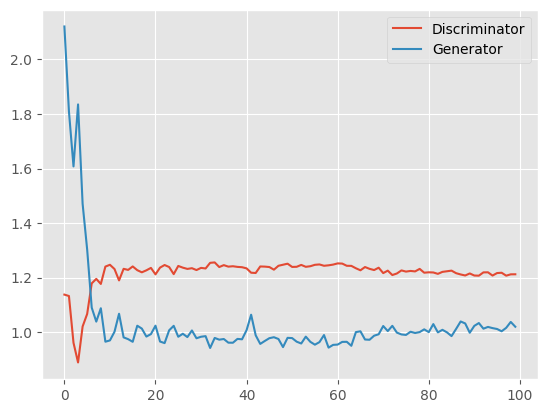

In [23]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

## Visualize image generation improvements

In [24]:
def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


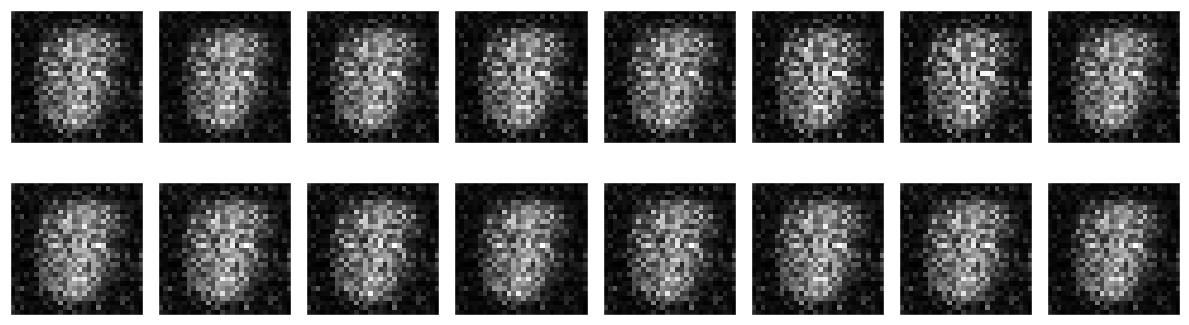

In [25]:
show_generated_images(epoch=1, n_cols=8)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


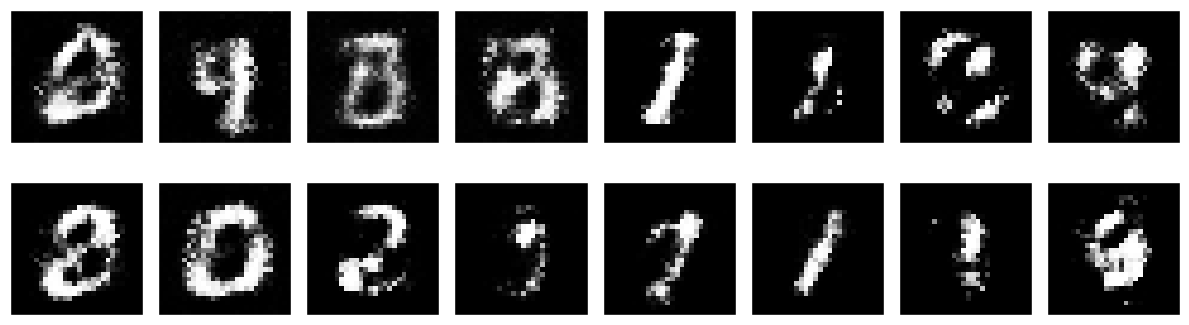

In [26]:
show_generated_images(epoch = 10, n_cols = 8)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


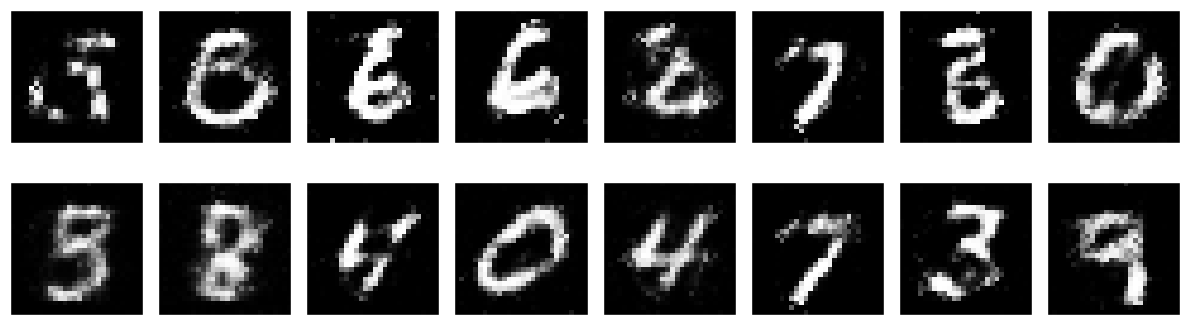

In [27]:
show_generated_images(epoch = 50, n_cols = 8)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


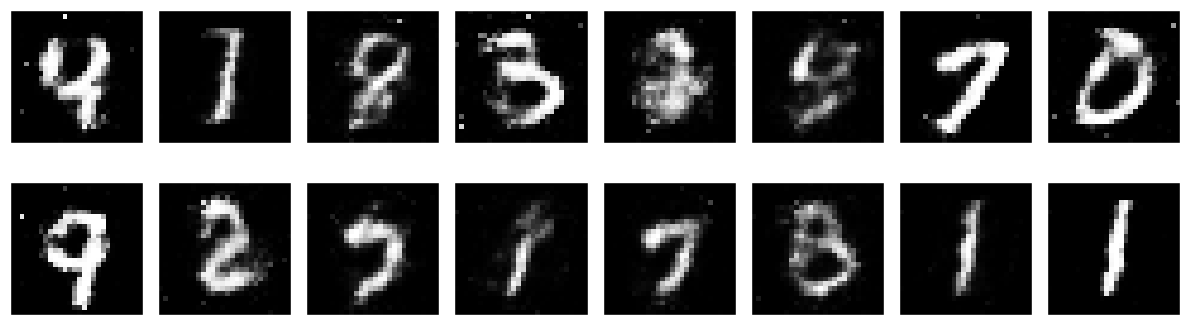

In [28]:
show_generated_images(epoch = 100, n_cols = 8)

## Test the network

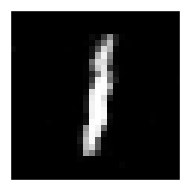

In [29]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))